In [39]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
import scipy.sparse as sparse

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [40]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1]]
                data.append(columns)

    return data

def import_csv2(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10] ]
                data.append(columns)

    return data

def import_csv3(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10], row[11] ]
                data.append(columns)

    return data

def import_csv4(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4]]
                data.append(columns)

    return data

In [41]:
tcp_cca = (['TcpCubic-0.000100', 'TcpBbr-0.000100', 
            'TcpQtColFair_1.2minRTT-0.000100', 'TcpQtColFair_1.5minRTT-0.000100',
            'TcpCubic-0.000010', 'TcpBbr-0.000010', 
            'TcpQtColFair_1.2minRTT-0.000010', 'TcpQtColFair_1.5minRTT-0.000010',
            'TcpCubic-0.000001', 'TcpBbr-0.000001', 
            'TcpQtColFair_1.2minRTT-0.000001', 'TcpQtColFair_1.5minRTT-0.000001'
           ])
BDP = 172
buffer_size = 1727 
print(buffer_size, tcp_cca)

1727 ['TcpCubic-0.000100', 'TcpBbr-0.000100', 'TcpQtColFair_1.2minRTT-0.000100', 'TcpQtColFair_1.5minRTT-0.000100', 'TcpCubic-0.000010', 'TcpBbr-0.000010', 'TcpQtColFair_1.2minRTT-0.000010', 'TcpQtColFair_1.5minRTT-0.000010', 'TcpCubic-0.000001', 'TcpBbr-0.000001', 'TcpQtColFair_1.2minRTT-0.000001', 'TcpQtColFair_1.5minRTT-0.000001']


In [42]:
num_flows = 5
cwnd = {}
agg_cwnd = {}
inflight = {}
rtt = {}

for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}


    agg_cwnd[algorithm] = {'time': list(), 'agg_cwnd': list(), 'agg_inflight': list(),
                'aveRtt': list(), 'agg_insThruput': list(), 'agg_aveThruput': list(), 
                'agg_insGoodput': list(), 'agg_aveGoodput': list(), 'agg_TxPkts': list(), 
                'agg_ReTxPkts': list(), 'fairness': list(), 'agg_cost': list()}
        
    for i in range(num_flows):
        cwnd[algorithm][i] = {'time': list(), 'cwnd': list(), 'inflight': list(),
                'rtt': list(), 'insThruput': list(), 'aveThruput': list(), 
                'insGoodput': list(), 'aveGoodput': list(), 'TxPkts': list(), 'ReTxPkts': list(), 
                'cost': list()}
                                       
        inflight[algorithm][i] = {'time': list(), 'inflight': list(), 'cwnd': list(), 
                                           'rtt': list(), 'cost': list()}
        rtt[algorithm][i] = {'time': list(), 'rtt': list()}

cwnd_files = []
agg_cwnd_files = []
inflight_files = []
rtt_files = []
                                               
for algorithm in tcp_cca:
    print(algorithm)
    
    agg_cwnd_files.append("../results/qt_lossy/" + str(algorithm) + "/" + 
                str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                "p-" + "Agg" + "-cwnd.data")
    cwnd_flows_files = []
    inflight_flows_files = []
    rtt_flows_files = []
    
    for i in range(num_flows):
        cwnd_flows_files.append("../results/qt_lossy/" + str(algorithm) + "/" + 
                    str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                    algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                    "p-flow" + str(i) + "-cwnd.data")
 #       inflight_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
 #                   str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
 #                   algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
 #                   "p-flow" + str(i) + "-inflight.data")
 #       rtt_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
 #                       str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
 #                       algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
 #                       "p-flow" + str(i) + "-rtt.data")
        
    cwnd_files.append(cwnd_flows_files)
    inflight_files.append(inflight_flows_files)
    rtt_files.append(rtt_flows_files)



TcpCubic-0.000100
TcpBbr-0.000100
TcpQtColFair_1.2minRTT-0.000100
TcpQtColFair_1.5minRTT-0.000100
TcpCubic-0.000010
TcpBbr-0.000010
TcpQtColFair_1.2minRTT-0.000010
TcpQtColFair_1.5minRTT-0.000010
TcpCubic-0.000001
TcpBbr-0.000001
TcpQtColFair_1.2minRTT-0.000001
TcpQtColFair_1.5minRTT-0.000001


In [43]:
print(agg_cwnd_files[0])
print(agg_cwnd_files[1])
print(agg_cwnd_files[2])

../results/qt_lossy/TcpCubic-0.000100/5-flows/100Mbps-20ms/1727p-btlqueue/TcpCubic-0.000100-5-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/qt_lossy/TcpBbr-0.000100/5-flows/100Mbps-20ms/1727p-btlqueue/TcpBbr-0.000100-5-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/qt_lossy/TcpQtColFair_1.2minRTT-0.000100/5-flows/100Mbps-20ms/1727p-btlqueue/TcpQtColFair_1.2minRTT-0.000100-5-flows-100Mbps-20ms-1727p-Agg-cwnd.data


In [44]:

for algorithm  in tcp_cca:
    index_alg = tcp_cca.index(algorithm)
    print(algorithm,index_alg)

    agg_cwnd_data_in = import_csv3(agg_cwnd_files[index_alg])
    for row in agg_cwnd_data_in: 
        agg_cwnd[algorithm]['time'].append({row[0]})
        agg_cwnd[algorithm]['agg_cwnd'].append({row[1]})
        agg_cwnd[algorithm]['agg_inflight'].append({row[2]})
        agg_cwnd[algorithm]['aveRtt'].append({row[3]})
        agg_cwnd[algorithm]['agg_insThruput'].append({row[4]})
        agg_cwnd[algorithm]['agg_aveThruput'].append({row[5]})
        agg_cwnd[algorithm]['agg_insGoodput'].append({row[6]})
        agg_cwnd[algorithm]['agg_aveGoodput'].append({row[7]})
        agg_cwnd[algorithm]['agg_TxPkts'].append({row[8]})
        agg_cwnd[algorithm]['agg_ReTxPkts'].append({row[9]})
        agg_cwnd[algorithm]['fairness'].append({row[10]})
        agg_cwnd[algorithm]['agg_cost'].append({row[11]})

    for i in range(num_flows):
        cwnd_data_in = import_csv2(cwnd_files[index_alg][i])
        #inflight_data_in = import_csv4(inflight_files[index_alg][i])
        #rtt_data_in = import_csv(rtt_files[index_alg][i])

        for row in cwnd_data_in:
            cwnd[algorithm][i]['time'].append({row[0]})
            cwnd[algorithm][i]['cwnd'].append({row[1]})
            cwnd[algorithm][i]['inflight'].append({row[2]})
            cwnd[algorithm][i]['rtt'].append({row[3]})
            cwnd[algorithm][i]['insThruput'].append({row[4]})
            cwnd[algorithm][i]['aveThruput'].append({row[5]})
            cwnd[algorithm][i]['insGoodput'].append({row[6]})
            cwnd[algorithm][i]['aveGoodput'].append({row[7]})
            cwnd[algorithm][i]['TxPkts'].append({row[8]})
            cwnd[algorithm][i]['ReTxPkts'].append({row[9]})
            cwnd[algorithm][i]['cost'].append({row[10]})


TcpCubic-0.000100 0
TcpBbr-0.000100 1
TcpQtColFair_1.2minRTT-0.000100 2
TcpQtColFair_1.5minRTT-0.000100 3
TcpCubic-0.000010 4
TcpBbr-0.000010 5
TcpQtColFair_1.2minRTT-0.000010 6
TcpQtColFair_1.5minRTT-0.000010 7
TcpCubic-0.000001 8
TcpBbr-0.000001 9
TcpQtColFair_1.2minRTT-0.000001 10
TcpQtColFair_1.5minRTT-0.000001 11


In [45]:
cwnd_time = []
cwnd_value = []
inflight_value = []
rtt_value = []
insThruput_value = []
aveThruput_value = []
insGoodput_value = []
aveGoodput_value = []
cost_value = []

inflight2_time = []
inflight2_value = []
cwnd2_value = []
rtt2_value = []
cost2_value = []
rtt3_time = []
rtt3_value = []

agg_cwnd_time = []
agg_cwnd_value = []
agg_inflight_value = []
agg_rtt_value = []
agg_insThruput_value = []
agg_aveThruput_value = []
agg_insGoodput_value = []
agg_aveGoodput_value = []
fairness_value = []
agg_cost_value = []

for algorithm in tcp_cca:
    print(algorithm)
    cwnd_time_ = []
    cwnd_value_ = []
    inflight_value_ = []
    rtt_value_ = []
    insThruput_value_ = []
    aveThruput_value_ = []
    insGoodput_value_ = []
    aveGoodput_value_ = []
    cost_value_ = []
    

    agg_cwnd_time.append(pd.DataFrame(agg_cwnd[algorithm]['time']))
    agg_cwnd_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cwnd']))
    agg_inflight_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_inflight']))
    agg_rtt_value.append(pd.DataFrame(agg_cwnd[algorithm]['aveRtt']))
    agg_insThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insThruput']))  
    agg_aveThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveThruput']))  
    agg_insGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insGoodput']))  
    agg_aveGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveGoodput'])) 
    fairness_value.append(pd.DataFrame(agg_cwnd[algorithm]['fairness'])) 
    agg_cost_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cost'])) 
    
    
    for i in range(num_flows):
        cwnd_time_.append(pd.DataFrame(cwnd[algorithm][i]['time']))
        cwnd_value_.append(pd.DataFrame(cwnd[algorithm][i]['cwnd']))
        cost_value_.append(pd.DataFrame(cwnd[algorithm][i]['cost']))
        inflight_value_.append(pd.DataFrame(cwnd[algorithm][i]['inflight']))
        rtt_value_.append(pd.DataFrame(cwnd[algorithm][i]['rtt']))
        insThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insThruput']))  
        aveThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveThruput']))  
        insGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insGoodput']))  
        aveGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveGoodput'])) 
        
    cwnd_time.append(cwnd_time_)
    cwnd_value.append(cwnd_value_)
    cost_value.append(cost_value_)
    inflight_value.append(inflight_value_)
    rtt_value.append(rtt_value_)
    insThruput_value.append(insThruput_value_)
    aveThruput_value.append(aveThruput_value_)
    insGoodput_value.append(insGoodput_value_)
    aveGoodput_value.append(aveGoodput_value_)


TcpCubic-0.000100
TcpBbr-0.000100
TcpQtColFair_1.2minRTT-0.000100
TcpQtColFair_1.5minRTT-0.000100
TcpCubic-0.000010
TcpBbr-0.000010
TcpQtColFair_1.2minRTT-0.000010
TcpQtColFair_1.5minRTT-0.000010
TcpCubic-0.000001
TcpBbr-0.000001
TcpQtColFair_1.2minRTT-0.000001
TcpQtColFair_1.5minRTT-0.000001


/tmp/ipykernel_7032/1561517575.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


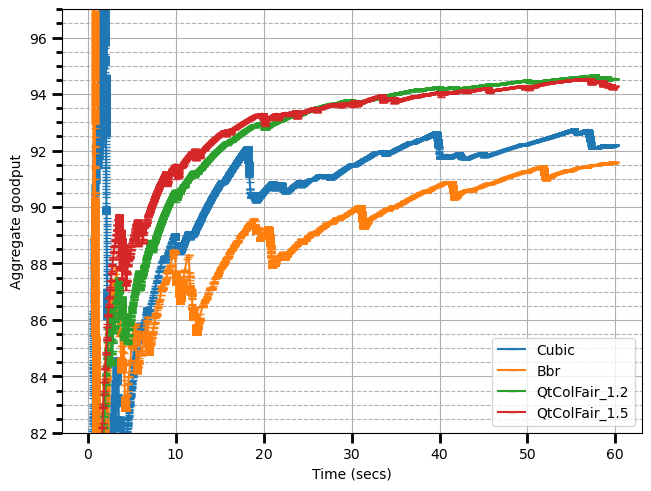

In [87]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_aveGoodput_value[0].to_numpy(dtype=float), '_-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),'_-',
        agg_cwnd_time[2].to_numpy(dtype=float), agg_aveGoodput_value[2].to_numpy(dtype=float),'_-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_aveGoodput_value[3].to_numpy(dtype=float),'_-'
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(82,97)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[0].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
            tcp_cca[1].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
            tcp_cca[2].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
            tcp_cca[3].replace('minRTT','').replace('Tcp','').replace('-0.000100','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('multiple_lossy_flows/5_lossy_flows_goodput_0.0001.png', transparent=True)

/tmp/ipykernel_7032/1992898479.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


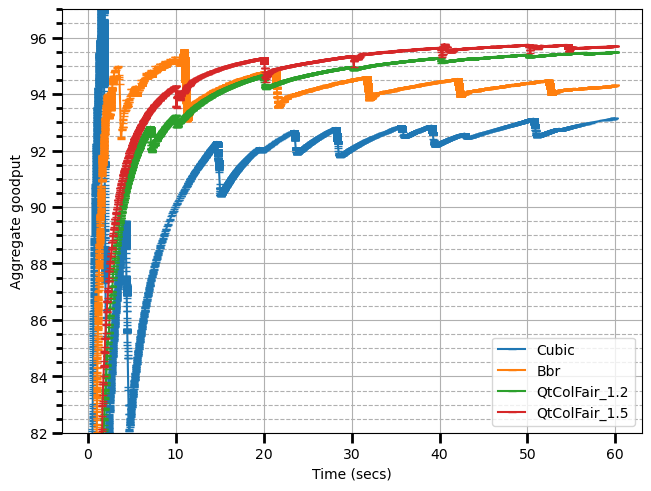

In [86]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[4].to_numpy(dtype=float), agg_aveGoodput_value[4].to_numpy(dtype=float), '_-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_aveGoodput_value[5].to_numpy(dtype=float),'_-',
        agg_cwnd_time[6].to_numpy(dtype=float), agg_aveGoodput_value[6].to_numpy(dtype=float),'_-',
        agg_cwnd_time[7].to_numpy(dtype=float), agg_aveGoodput_value[7].to_numpy(dtype=float),'_-'
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(82,97)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[4].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
            tcp_cca[5].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
            tcp_cca[6].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
            tcp_cca[7].replace('minRTT','').replace('Tcp','').replace('-0.000010','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('multiple_lossy_flows/5_lossy_flows_goodputt_0.00001.png', transparent=True)

/tmp/ipykernel_7032/184122970.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


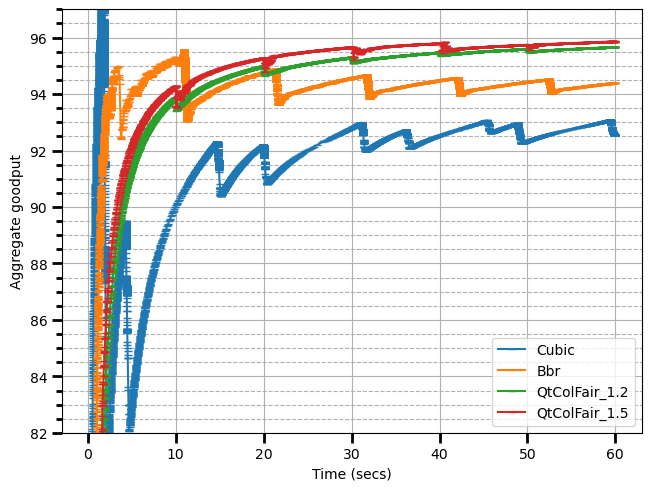

In [85]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[8].to_numpy(dtype=float), agg_aveGoodput_value[8].to_numpy(dtype=float), '_-',
        agg_cwnd_time[9].to_numpy(dtype=float), agg_aveGoodput_value[9].to_numpy(dtype=float),'_-',
        agg_cwnd_time[10].to_numpy(dtype=float), agg_aveGoodput_value[10].to_numpy(dtype=float),'_-',
        agg_cwnd_time[11].to_numpy(dtype=float), agg_aveGoodput_value[11].to_numpy(dtype=float),'_-'
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(82,97)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[8].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
            tcp_cca[9].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
            tcp_cca[10].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
            tcp_cca[11].replace('minRTT','').replace('Tcp','').replace('-0.000001','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('multiple_lossy_flows/5_lossy_flows_goodputt_0.000001.png', transparent=True)

/tmp/ipykernel_7032/1128541843.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


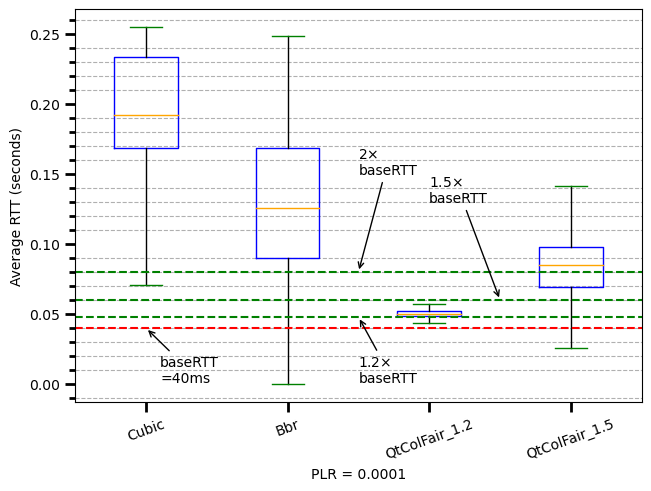

In [79]:
x0 = agg_rtt_value[0][0].to_numpy(dtype=float)
x1 = agg_rtt_value[1][0].to_numpy(dtype=float)
x2 = agg_rtt_value[2][0].to_numpy(dtype=float)
x3 = agg_rtt_value[3][0].to_numpy(dtype=float)
x4 = agg_rtt_value[4][0].to_numpy(dtype=float)
x5 = agg_rtt_value[5][0].to_numpy(dtype=float)
x6 = agg_rtt_value[6][0].to_numpy(dtype=float)
x7 = agg_rtt_value[7][0].to_numpy(dtype=float)
x8 = agg_rtt_value[8][0].to_numpy(dtype=float)
x9 = agg_rtt_value[9][0].to_numpy(dtype=float)
x10 = agg_rtt_value[10][0].to_numpy(dtype=float)
x11 = agg_rtt_value[11][0].to_numpy(dtype=float)

fig, ax1 = plt.subplots(constrained_layout=True)
plt.boxplot ([x0, x1, x2, x3], 
             labels=[tcp_cca[0].replace('Tcp','').replace('-0.000100',''), 
                     tcp_cca[1].replace('Tcp','').replace('-0.000100',''),  
                     tcp_cca[2].replace('minRTT','').replace('Tcp','').replace('-0.000100',''), 
                     tcp_cca[3].replace('minRTT','').replace('Tcp','').replace('-0.000100','')
                    ],
            boxprops=dict(color='blue'),
             #whiskerprops=dict(color='red'),
             capprops=dict(color='green'),
             medianprops=dict(color='orange'),
             showfliers=False
             #flierprops=dict(markerfacecolor='red', marker='.')
            )
plt.xticks(rotation = 20)

plt.axhline(y = 0.04, color = 'red', linestyle='--')
plt.axhline(y = 0.048, color = 'g', linestyle='--')
plt.axhline(y = 0.060, color = 'g', linestyle='--')
plt.axhline(y = 0.080, color = 'g', linestyle='--')

arrowprops = dict(
    arrowstyle="->")
ax1.annotate('baseRTT\n=40ms', xy=(1,0.04), xytext=(1.1,0.001), arrowprops=arrowprops)
ax1.annotate(r'1.2$\times$'+'\nbaseRTT', xy=(2.5,0.048), xytext=(2.5,0.001), arrowprops=arrowprops)
ax1.annotate(r'2$\times$'+'\nbaseRTT', xy=(2.5,0.08), xytext=(2.5,0.15), arrowprops=arrowprops)
ax1.annotate(r'1.5$\times$'+'\nbaseRTT', xy=(3.5,0.060), xytext=(3,0.13), arrowprops=arrowprops)


ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')
plt.ylabel(r'Average RTT (seconds)')
plt.xlabel(r'PLR = 0.0001')

plt.show
plt.savefig('multiple_lossy_flows/5_lossy_flows_rtt_boxplot_0.0001.png', transparent=True)

/tmp/ipykernel_7032/613326063.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


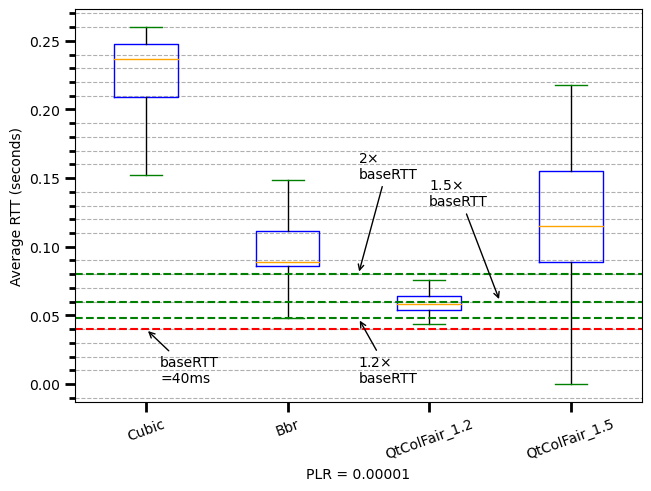

In [80]:
fig, ax1 = plt.subplots(constrained_layout=True)
plt.boxplot ([x4, x5, x6, x7], 
             labels=[tcp_cca[4].replace('Tcp','').replace('-0.000010',''), 
                     tcp_cca[5].replace('Tcp','').replace('-0.000010',''),  
                     tcp_cca[6].replace('minRTT','').replace('Tcp','').replace('-0.000010',''), 
                     tcp_cca[7].replace('minRTT','').replace('Tcp','').replace('-0.000010','')
                    ],
            boxprops=dict(color='blue'),
             #whiskerprops=dict(color='red'),
             capprops=dict(color='green'),
             medianprops=dict(color='orange'),
             showfliers=False
             #flierprops=dict(markerfacecolor='red', marker='.')
            )
plt.xticks(rotation = 20)

plt.axhline(y = 0.04, color = 'red', linestyle='--')
plt.axhline(y = 0.048, color = 'g', linestyle='--')
plt.axhline(y = 0.060, color = 'g', linestyle='--')
plt.axhline(y = 0.080, color = 'g', linestyle='--')

arrowprops = dict(
    arrowstyle="->")
ax1.annotate('baseRTT\n=40ms', xy=(1,0.04), xytext=(1.1,0.001), arrowprops=arrowprops)
ax1.annotate(r'1.2$\times$'+'\nbaseRTT', xy=(2.5,0.048), xytext=(2.5,0.001), arrowprops=arrowprops)
ax1.annotate(r'2$\times$'+'\nbaseRTT', xy=(2.5,0.08), xytext=(2.5,0.15), arrowprops=arrowprops)
ax1.annotate(r'1.5$\times$'+'\nbaseRTT', xy=(3.5,0.060), xytext=(3,0.13), arrowprops=arrowprops)


ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')
plt.ylabel(r'Average RTT (seconds)')
plt.xlabel(r'PLR = 0.00001')

plt.show
plt.savefig('multiple_lossy_flows/5_lossy_flows_rtt_boxplot_0.00001.png', transparent=True)

/tmp/ipykernel_7032/1218105497.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


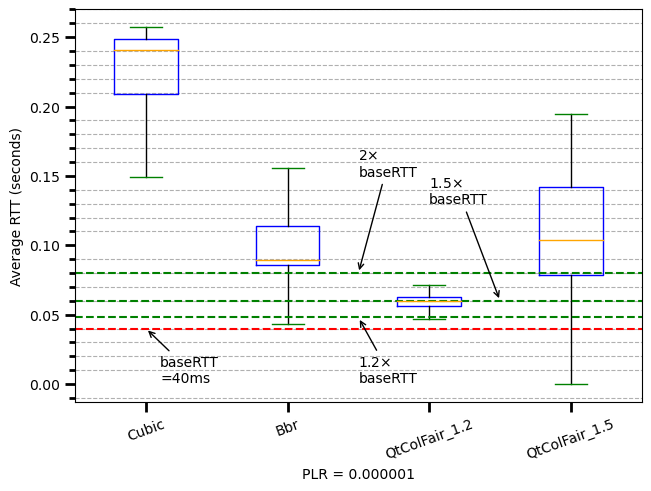

In [81]:
fig, ax1 = plt.subplots(constrained_layout=True)
plt.boxplot ([x8, x9, x10, x11], 
             labels=[tcp_cca[8].replace('Tcp','').replace('-0.000001',''), 
                     tcp_cca[9].replace('Tcp','').replace('-0.000001',''),  
                     tcp_cca[10].replace('minRTT','').replace('Tcp','').replace('-0.000001',''), 
                     tcp_cca[11].replace('minRTT','').replace('Tcp','').replace('-0.000001','')
                    ],
            boxprops=dict(color='blue'),
             #whiskerprops=dict(color='red'),
             capprops=dict(color='green'),
             medianprops=dict(color='orange'),
             showfliers=False
             #flierprops=dict(markerfacecolor='red', marker='.')
            )
plt.xticks(rotation = 20)

plt.axhline(y = 0.04, color = 'red', linestyle='--')
plt.axhline(y = 0.048, color = 'g', linestyle='--')
plt.axhline(y = 0.060, color = 'g', linestyle='--')
plt.axhline(y = 0.080, color = 'g', linestyle='--')

arrowprops = dict(
    arrowstyle="->")
ax1.annotate('baseRTT\n=40ms', xy=(1,0.04), xytext=(1.1,0.001), arrowprops=arrowprops)
ax1.annotate(r'1.2$\times$'+'\nbaseRTT', xy=(2.5,0.048), xytext=(2.5,0.001), arrowprops=arrowprops)
ax1.annotate(r'2$\times$'+'\nbaseRTT', xy=(2.5,0.08), xytext=(2.5,0.15), arrowprops=arrowprops)
ax1.annotate(r'1.5$\times$'+'\nbaseRTT', xy=(3.5,0.060), xytext=(3,0.13), arrowprops=arrowprops)


ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')
plt.ylabel(r'Average RTT (seconds)')
plt.xlabel(r'PLR = 0.000001')

plt.show
plt.savefig('multiple_lossy_flows/5_lossy_flows_rtt_boxplot_0.000001.png', transparent=True)